# Logistic Regression Model for TANAP Boundaries Prediction

This notebook implements and evaluates a Logistic Regression model for predicting TANAP boundaries in historical document scans.

## Model Overview
- **Task**: Multi-class classification (NONE, START, MIDDLE, END)
- **Algorithm**: Logistic Regression with regularization
- **Features**: XML layout features + XMI NER features + sequence features
- **Evaluation**: Accuracy, F1-score, precision, recall, confusion matrix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

In [2]:
# Load the feature dataset
df = pd.read_csv('../data/train/features_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['TANAP Boundaries'].value_counts())
print(f"\nTarget percentages:")
print(df['TANAP Boundaries'].value_counts(normalize=True) * 100)

Dataset shape: (16774, 69)

Columns: ['Scan File_Name', 'TANAP Boundaries', 'num_text_regions', 'num_text_lines', 'num_words', 'avg_region_area', 'total_text_area', 'page_coverage_ratio', 'regions_top_half', 'regions_bottom_half', 'regions_left_half', 'regions_right_half', 'header_regions', 'paragraph_regions', 'list_regions', 'table_regions', 'other_regions', 'region_area_variance', 'vertical_spacing_avg', 'horizontal_spacing_avg', 'has_reading_order', 'reading_order_complexity', 'num_sentences', 'num_tokens', 'num_named_entities', 'person_entities', 'location_entities', 'organization_entities', 'date_entities', 'money_entities', 'misc_entities', 'avg_sentence_length', 'avg_token_length', 'token_length_variance', 'has_headings', 'num_headings', 'has_punctuation', 'punctuation_density', 'dutch_indicators', 'formal_language_score', 'numeric_content_ratio', 'prev_num_text_regions', 'next_num_text_regions', 'delta_prev_num_text_regions', 'delta_next_num_text_regions', 'prev_num_text_lines

In [3]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['Scan File_Name', 'TANAP Boundaries']]
X = df[feature_cols]
y = df['TANAP Boundaries']

print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10

# Check for missing values
missing_data = X.isnull().sum()
if missing_data.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_data[missing_data > 0])
    # Fill missing values with median
    X = X.fillna(X.median())
else:
    print("\nNo missing values found.")

Number of features: 67
Feature columns: ['num_text_regions', 'num_text_lines', 'num_words', 'avg_region_area', 'total_text_area', 'page_coverage_ratio', 'regions_top_half', 'regions_bottom_half', 'regions_left_half', 'regions_right_half']...

No missing values found.


In [4]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Label encoding:
0: END
1: MIDDLE
2: NONE
3: START

Training set shape: (13419, 67)
Test set shape: (3355, 67)

Training set distribution:
0      872
1    10446
2     1228
3      873
Name: count, dtype: int64

Test set distribution:
0     218
1    2612
2     307
3     218
Name: count, dtype: int64


## Feature Scaling

In [5]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Training features mean: {X_train_scaled.mean():.6f}")
print(f"Training features std: {X_train_scaled.std():.6f}")
print(f"Test features mean: {X_test_scaled.mean():.6f}")
print(f"Test features std: {X_test_scaled.std():.6f}")

Feature scaling completed.
Training features mean: 0.000000
Training features std: 0.810380
Test features mean: 0.009571
Test features std: 0.819083


## Model Training and Hyperparameter Tuning

In [6]:
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

# Create logistic regression model
lr_model = LogisticRegression(random_state=42, multi_class='ovr')

# Perform grid search with cross-validation
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    lr_model, 
    param_grid, 
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.8098


In [7]:
# Train final model with best parameters
best_lr_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_lr_model.predict(X_train_scaled)
y_test_pred = best_lr_model.predict(X_test_scaled)

# Calculate training and test scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Training Accuracy: 0.8379
Test Accuracy: 0.8387
Training F1-score: 0.8102
Test F1-score: 0.8120


## Model Evaluation

In [8]:
# Detailed classification report
class_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(
    y_test, y_test_pred, 
    target_names=class_names,
    digits=4
))

Classification Report:
              precision    recall  f1-score   support

         END     0.5522    0.1697    0.2596       218
      MIDDLE     0.8672    0.9602    0.9113      2612
        NONE     0.7305    0.7329    0.7317       307
       START     0.5000    0.2018    0.2876       218

    accuracy                         0.8387      3355
   macro avg     0.6625    0.5162    0.5476      3355
weighted avg     0.8104    0.8387    0.8120      3355



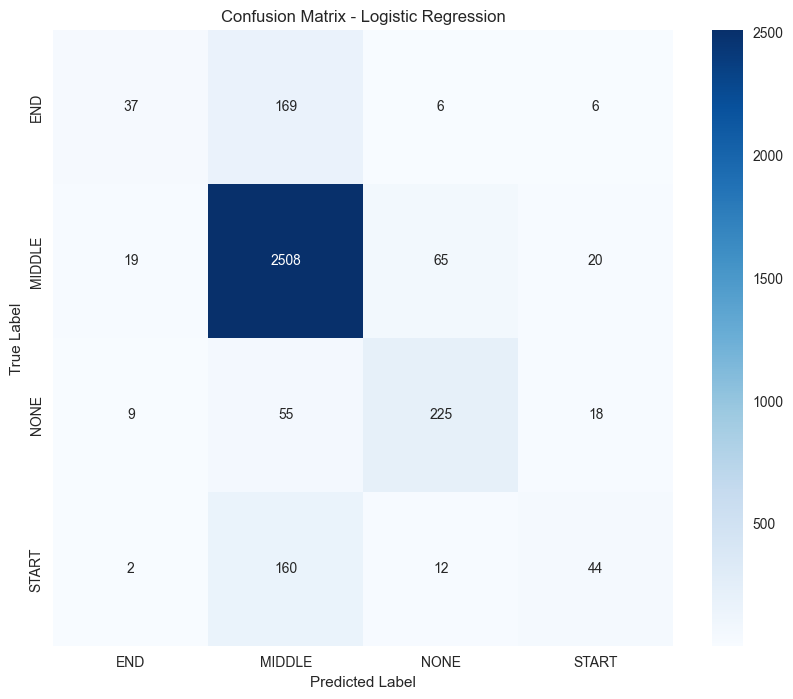


Per-class Metrics:
    Class  Precision  Recall  F1-Score  Support
0     END     0.5522  0.1697    0.2596      218
1  MIDDLE     0.8672  0.9602    0.9113     2612
2    NONE     0.7305  0.7329    0.7317      307
3   START     0.5000  0.2018    0.2876      218


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class Metrics:")
print(metrics_df.round(4))

## Feature Importance Analysis

Top 20 Most Important Features:
                          Feature  Importance
59  rolling_mean_num_text_regions    2.774027
39          prev_num_text_regions    0.780775
40          next_num_text_regions    0.772831
43            prev_num_text_lines    0.601525
44            next_num_text_lines    0.563128
1                  num_text_lines    0.501244
29            avg_sentence_length    0.497870
34                has_punctuation    0.483027
21                     num_tokens    0.448445
30               avg_token_length    0.413145
28                  misc_entities    0.393731
22             num_named_entities    0.393731
14                  other_regions    0.382574
45      delta_prev_num_text_lines    0.378802
42    delta_next_num_text_regions    0.368653
0                num_text_regions    0.361404
8               regions_left_half    0.361404
6                regions_top_half    0.361404
41    delta_prev_num_text_regions    0.361384
58          delta_next_num_tokens    0.338082


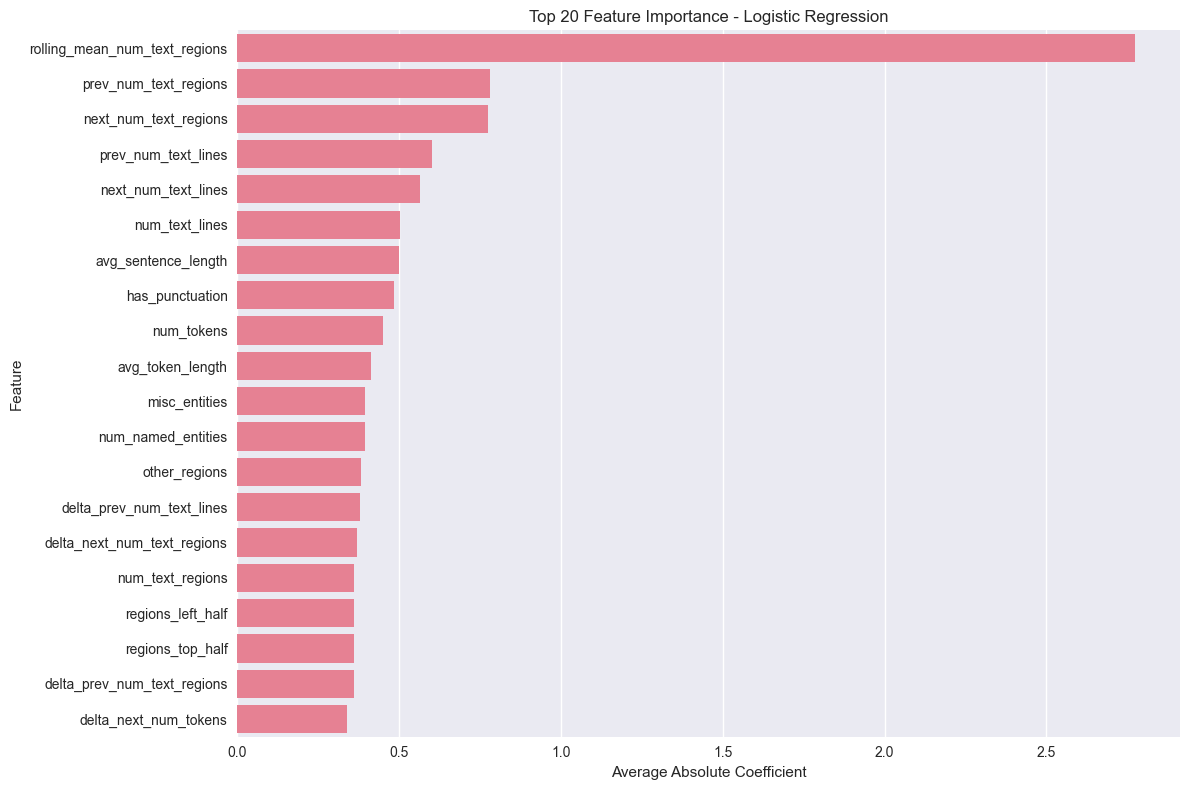

In [10]:
# Get feature importance (coefficients)
# For multi-class, we'll look at the average absolute coefficient across classes
coefficients = best_lr_model.coef_
feature_importance = np.mean(np.abs(coefficients), axis=0)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))

# Plot top features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(data=top_features, y='Feature', x='Importance')
plt.title('Top 20 Feature Importance - Logistic Regression')
plt.xlabel('Average Absolute Coefficient')
plt.tight_layout()
plt.show()

## Cross-Validation Analysis

5-Fold Cross-Validation Results:
Accuracy: 0.8376 (+/- 0.0061)
F1-Score: 0.8098 (+/- 0.0080)


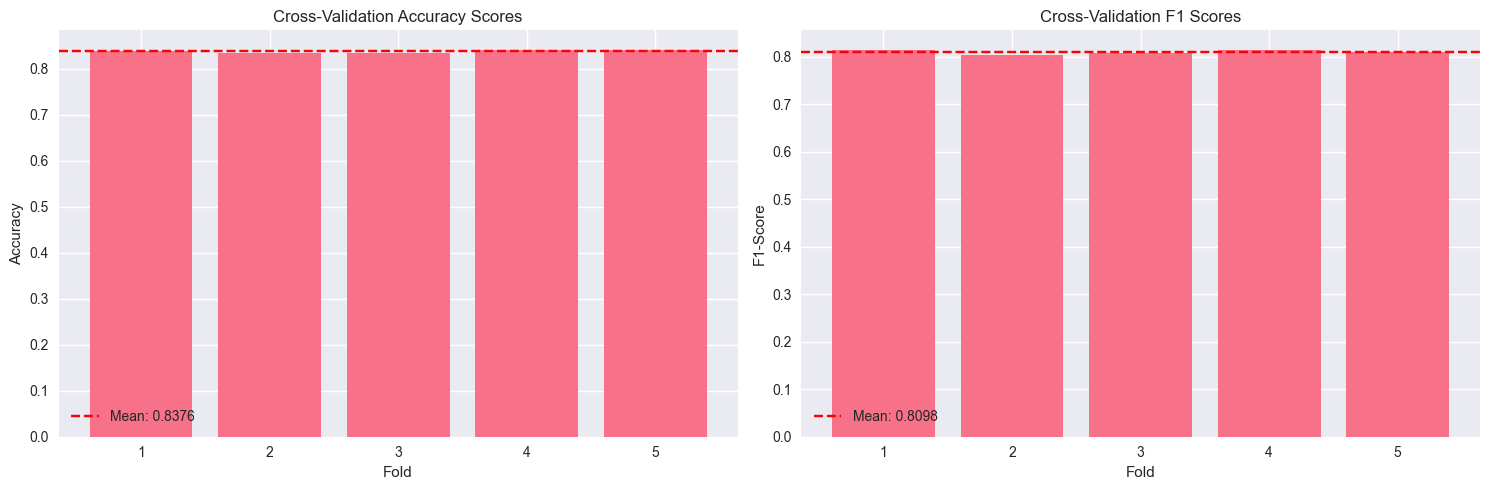

In [11]:
# Perform k-fold cross-validation
cv_scores_accuracy = cross_val_score(
    best_lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy'
)
cv_scores_f1 = cross_val_score(
    best_lr_model, X_train_scaled, y_train, cv=5, scoring='f1_weighted'
)

print("5-Fold Cross-Validation Results:")
print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# Plot CV scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(range(1, 6), cv_scores_accuracy)
ax1.axhline(y=cv_scores_accuracy.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_accuracy.mean():.4f}')
ax1.set_title('Cross-Validation Accuracy Scores')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.bar(range(1, 6), cv_scores_f1)
ax2.axhline(y=cv_scores_f1.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_f1.mean():.4f}')
ax2.set_title('Cross-Validation F1 Scores')
ax2.set_xlabel('Fold')
ax2.set_ylabel('F1-Score')
ax2.legend()

plt.tight_layout()
plt.show()

## Results Summary and Analysis

In [12]:
# Create comprehensive results summary
results_summary = {
    'Model': 'Logistic Regression',
    'Best Parameters': grid_search.best_params_,
    'Training Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Training F1-Score': train_f1,
    'Test F1-Score': test_f1,
    'CV Accuracy Mean': cv_scores_accuracy.mean(),
    'CV Accuracy Std': cv_scores_accuracy.std(),
    'CV F1-Score Mean': cv_scores_f1.mean(),
    'CV F1-Score Std': cv_scores_f1.std(),
    'Number of Features': len(feature_cols),
    'Training Samples': len(X_train),
    'Test Samples': len(X_test)
}

print("LOGISTIC REGRESSION MODEL - FINAL RESULTS")
print("=" * 50)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Analysis and insights
print("\n" + "=" * 50)
print("ANALYSIS AND INSIGHTS")
print("=" * 50)

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:
    print("⚠️  Potential overfitting detected (training accuracy >> test accuracy)")
else:
    print("✅ Good generalization (no significant overfitting)")

# Model performance assessment
if test_accuracy > 0.8:
    print("✅ High model performance (accuracy > 80%)")
elif test_accuracy > 0.7:
    print("⚡ Moderate model performance (accuracy 70-80%)")
else:
    print("⚠️  Low model performance (accuracy < 70%)")

# Class balance analysis
test_distribution = pd.Series(y_test).value_counts(normalize=True)
if test_distribution.max() > 0.6:
    print("⚠️  Imbalanced dataset - consider class weighting or resampling")
else:
    print("✅ Reasonably balanced dataset")

print(f"\n📊 Most important features for classification:")
for i, (feature, importance) in enumerate(feature_importance_df.head(5).values):
    print(f"   {i+1}. {feature}: {importance:.6f}")

LOGISTIC REGRESSION MODEL - FINAL RESULTS
Model: Logistic Regression
Best Parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Training Accuracy: 0.8379
Test Accuracy: 0.8387
Training F1-Score: 0.8102
Test F1-Score: 0.8120
CV Accuracy Mean: 0.8376
CV Accuracy Std: 0.0031
CV F1-Score Mean: 0.8098
CV F1-Score Std: 0.0040
Number of Features: 67
Training Samples: 13419
Test Samples: 3355

ANALYSIS AND INSIGHTS
✅ Good generalization (no significant overfitting)
✅ High model performance (accuracy > 80%)
⚠️  Imbalanced dataset - consider class weighting or resampling

📊 Most important features for classification:
   1. rolling_mean_num_text_regions: 2.774027
   2. prev_num_text_regions: 0.780775
   3. next_num_text_regions: 0.772831
   4. prev_num_text_lines: 0.601525
   5. next_num_text_lines: 0.563128


## Save Model and Results

In [13]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model and preprocessing objects
joblib.dump(best_lr_model, '../models/logistic_regression_model.pkl')
joblib.dump(scaler, '../models/logistic_regression_scaler.pkl')
joblib.dump(label_encoder, '../models/label_encoder.pkl')

# Save results summary
results_df = pd.DataFrame([results_summary])
results_df.to_csv('../models/logistic_regression_results.csv', index=False)

# Save feature importance
feature_importance_df.to_csv('../models/logistic_regression_feature_importance.csv', index=False)

print("Model and results saved successfully!")
print("Saved files:")
print("  - ../models/logistic_regression_model.pkl")
print("  - ../models/logistic_regression_scaler.pkl")
print("  - ../models/label_encoder.pkl")
print("  - ../models/logistic_regression_results.csv")
print("  - ../models/logistic_regression_feature_importance.csv")

Model and results saved successfully!
Saved files:
  - ../models/logistic_regression_model.pkl
  - ../models/logistic_regression_scaler.pkl
  - ../models/label_encoder.pkl
  - ../models/logistic_regression_results.csv
  - ../models/logistic_regression_feature_importance.csv
